In [1]:
%matplotlib inline

import json
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from scipy import interpolate
from operator import itemgetter
import matplotlib as mpl
from astropy.stats import sigma_clip

plt.style.use('seaborn-white')
mpl.rcParams.update({'font.size': 16})

## Optimal Lowercut Method: Shifting the Most Precise Lowercut Measurement

The lowercut value appears to be key to TAME assigning a good equivalent width measurement for a given line. This notebook uses measurements taken from ~20 stars at 10 different lowercut values to find the best lowercut value per line. Prior to this method, we've been attempting to find the optimal lowercut value as the value where the typical (or average) percent difference with respect to our known values is minimized. We've found that the solution space for these measurements can be broad and certain solutions have large spread. Therefore, this method takes a different approach. We select the optimal lowercut value as the value where the spread in percent different is minimized and apply an offset to get the percent difference of that lowercut value centered on zero.

In [64]:
# Select Datasets and extract equivalent widths
outputs = glob.glob("tame-1.1.0/*sm3.json")
by_hand = glob.glob("tame-1.1.0/*.ew")
lc_range = np.arange(0.95,0.995,0.0001)
len_range = 10


d = {'JSON File': outputs, 'By-Hand File': by_hand}
disp_df = pd.DataFrame(data=d)
disp_df

,By-Hand File,JSON File
0,tame-1.1.0/col110_1134red_oned_25jan14.ew,tame-1.1.0/col110_1134red_oned_25jan14_sm3.json
1,tame-1.1.0/col110_2119red_oned_26jan14.ew,tame-1.1.0/col110_2119red_oned_26jan14_sm3.json
2,tame-1.1.0/col110_2129red_oned_25jan14.ew,tame-1.1.0/col110_2129red_oned_25jan14_sm3.json
3,tame-1.1.0/col110_2223red_oned_26jan14.ew,tame-1.1.0/col110_2223red_oned_26jan14_sm3.json
4,tame-1.1.0/col110_3122red_oned_mar2014.ew,tame-1.1.0/col110_3122red_oned_mar2014_sm3.json
5,tame-1.1.0/col110_3144red_oned_mar2014.ew,tame-1.1.0/col110_3144red_oned_mar2014_sm3.json
6,tame-1.1.0/col110_3244red_oned_25jan14.ew,tame-1.1.0/col110_3244red_oned_25jan14_sm3.json
7,tame-1.1.0/col110_4260red_oned_26jan14.ew,tame-1.1.0/col110_4260red_oned_26jan14_sm3.json
8,tame-1.1.0/col110_5125red_oned_26jan14.ew,tame-1.1.0/col110_5125red_oned_26jan14_sm3.json
9,tame-1.1.0/ngc2204_1124red_oned_05jan14.ew,tame-1.1.0/ngc2204_1124red_oned_05jan14_sm3.json


In [147]:
# Find optimal lowercut value
write_out = False
plot = False

with open(outputs[0]) as jsonfile:
    jsondata = json.load(jsonfile)
    key = list(jsondata.keys())[2]
    lowcuts = [cut for cut,ew in jsondata[key]]
    line_list = list(jsondata.keys())
    line_list = np.array(sorted(np.array(line_list).astype(float))).astype(str)

if write_out:
    f_out = open("as.txt","w")
solns_dev = []
closest_dev = []
closest_pdiffs = []

line_dict = {}
for line in line_list[:]:
    if plot:
        plt.figure(figsize=(10,5))
        plt.grid()
    pdiff_all = []
    hand_all = []
    for i in range(len(outputs)):
        if 'ngc2204_3321red' in outputs[i]:
            continue
        with open(outputs[i]) as jsonfile, open(by_hand[i]) as ewfile:
            jsondata = json.load(jsonfile)
            handdata = pd.read_csv(ewfile, delim_whitespace = True, header = None)[[0,4]]
            hand_dict = dict(zip([str(i) for i in handdata[0].tolist()], handdata[4].tolist()))
            key = line
            lowercut = [cut for cut,ew in jsondata[key]]
            ew_meas = [ew for cut,ew in jsondata[key]]
            #print(outputs[i])
            #print(ew_meas)
            #print(hand_dict[key])
            
            label = disp_df['JSON File'][i].split('/')[-1].split('.')[0]
            if hand_dict[key] == 0:
                continue
            if len(lowercut) < len_range:
                continue
            #plt.plot(lowercut,ew_pdiff,'.',color='k')
            ew_pdiff = ((np.array(ew_meas)-hand_dict[key])/hand_dict[key]) * 100
            ew_absdiff = np.array(ew_meas) - hand_dict[key]
            pdiff_all.append(ew_absdiff)
            hand_all.append(hand_dict[key])
    

    pdiff_all = np.array(pdiff_all,dtype='object').T
    #print(hand_all)
    
    #Sigma Clip
    sigma = 5
    pdiff_sclip = [np.ma.compressed(sigma_clip(np.array(pdiff_all[lowcuts.index(lc_val)]).astype(float),sigma=sigma)) 
                   for lc_val in lowcuts]
    #print(len(pdiff_all))
    if plot:
        for pdiff in np.array(pdiff_all).T:
            plt.plot(lowcuts,pdiff,'.',color='k')
    avg_pdiffs = [np.mean(pdiff_sclip[lowcuts.index(lc_val)]) for lc_val in lowcuts]
    std_pdiffs = [np.std(pdiff_sclip[lowcuts.index(lc_val)]) for lc_val in lowcuts]
    
    if plot:
        plt.plot(lowcuts, avg_pdiffs)

    best_lowcut = lowcuts[np.argmin(std_pdiffs)] #Best lowcut is solution with smallest spread (not solution that has the closest percent difference)
    pdiff_offset = avg_pdiffs[np.argmin(std_pdiffs)] # The mean percent difference associated with the chosen lowcut value is the offset value
    if plot:
        plt.title(line)
        print("======")
        print(line)
        print(best_lowcut, np.min(std_pdiffs))
        print(std_pdiffs)
        if np.min(std_pdiffs) > 10:
            print("WARNING: Large Standard Deviation, Bimodal?")
    
    line_dict[line] = (best_lowcut, np.min(std_pdiffs), pdiff_offset,np.mean(hand_all))
if write_out:
    f_out.close()
    

56.618867814
3.06207957768


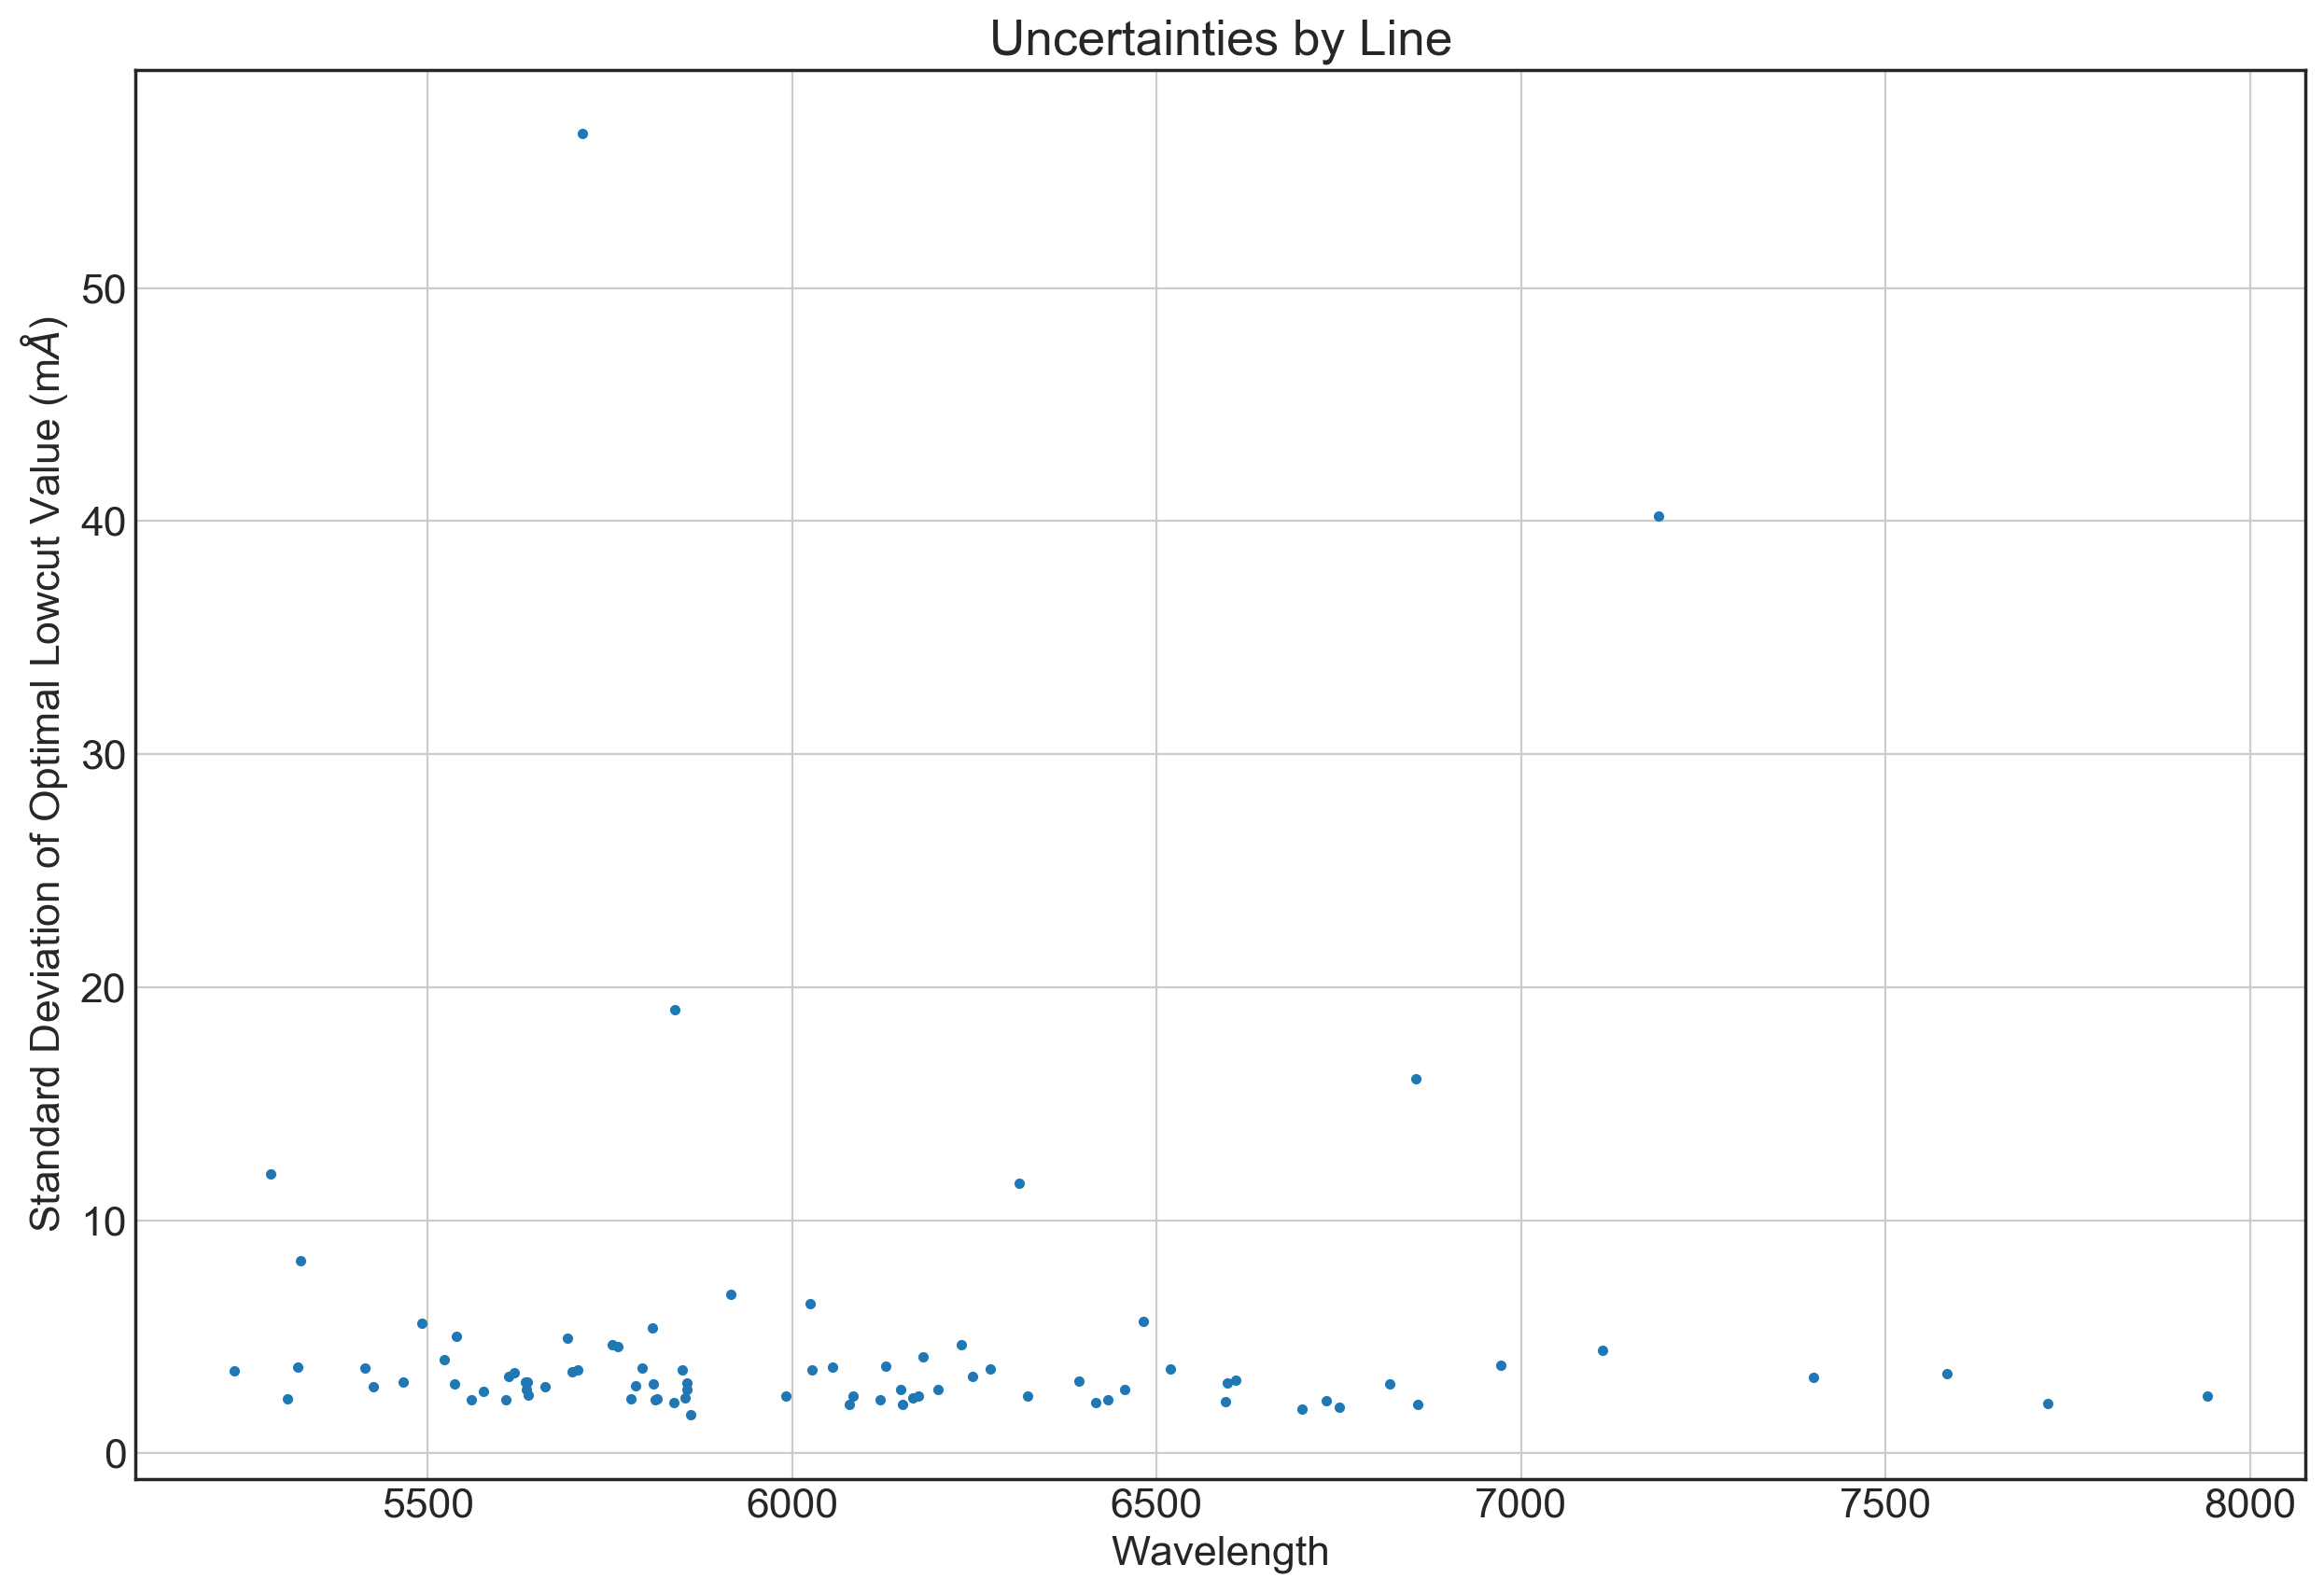

In [148]:
#print(list(line_dict.keys()))
opt_vals = [line_dict.get(key)[0] for key in line_dict.keys()]
val_unc = [line_dict.get(key)[1] for key in line_dict.keys()]
val_offst = [line_dict.get(key)[2] for key in line_dict.keys()]
hand_meas = [line_dict.get(key)[3] for key in line_dict.keys()]
fig = plt.figure(figsize=(15,10))
plt.grid()
fig.dpi = 200
print(max(val_unc))
plt.plot(list(line_dict.keys()),val_unc,'.')
plt.title("Uncertainties by Line")
plt.ylabel(r"Standard Deviation of Optimal Lowcut Value (m$\AA$)")
#plt.ylabel("Standard Deviation of Optimal Lowcut Value (%)")
plt.xlabel("Wavelength")
print(np.median(val_unc))

plt.savefig("absdiff_uncs.png")

#Table instead

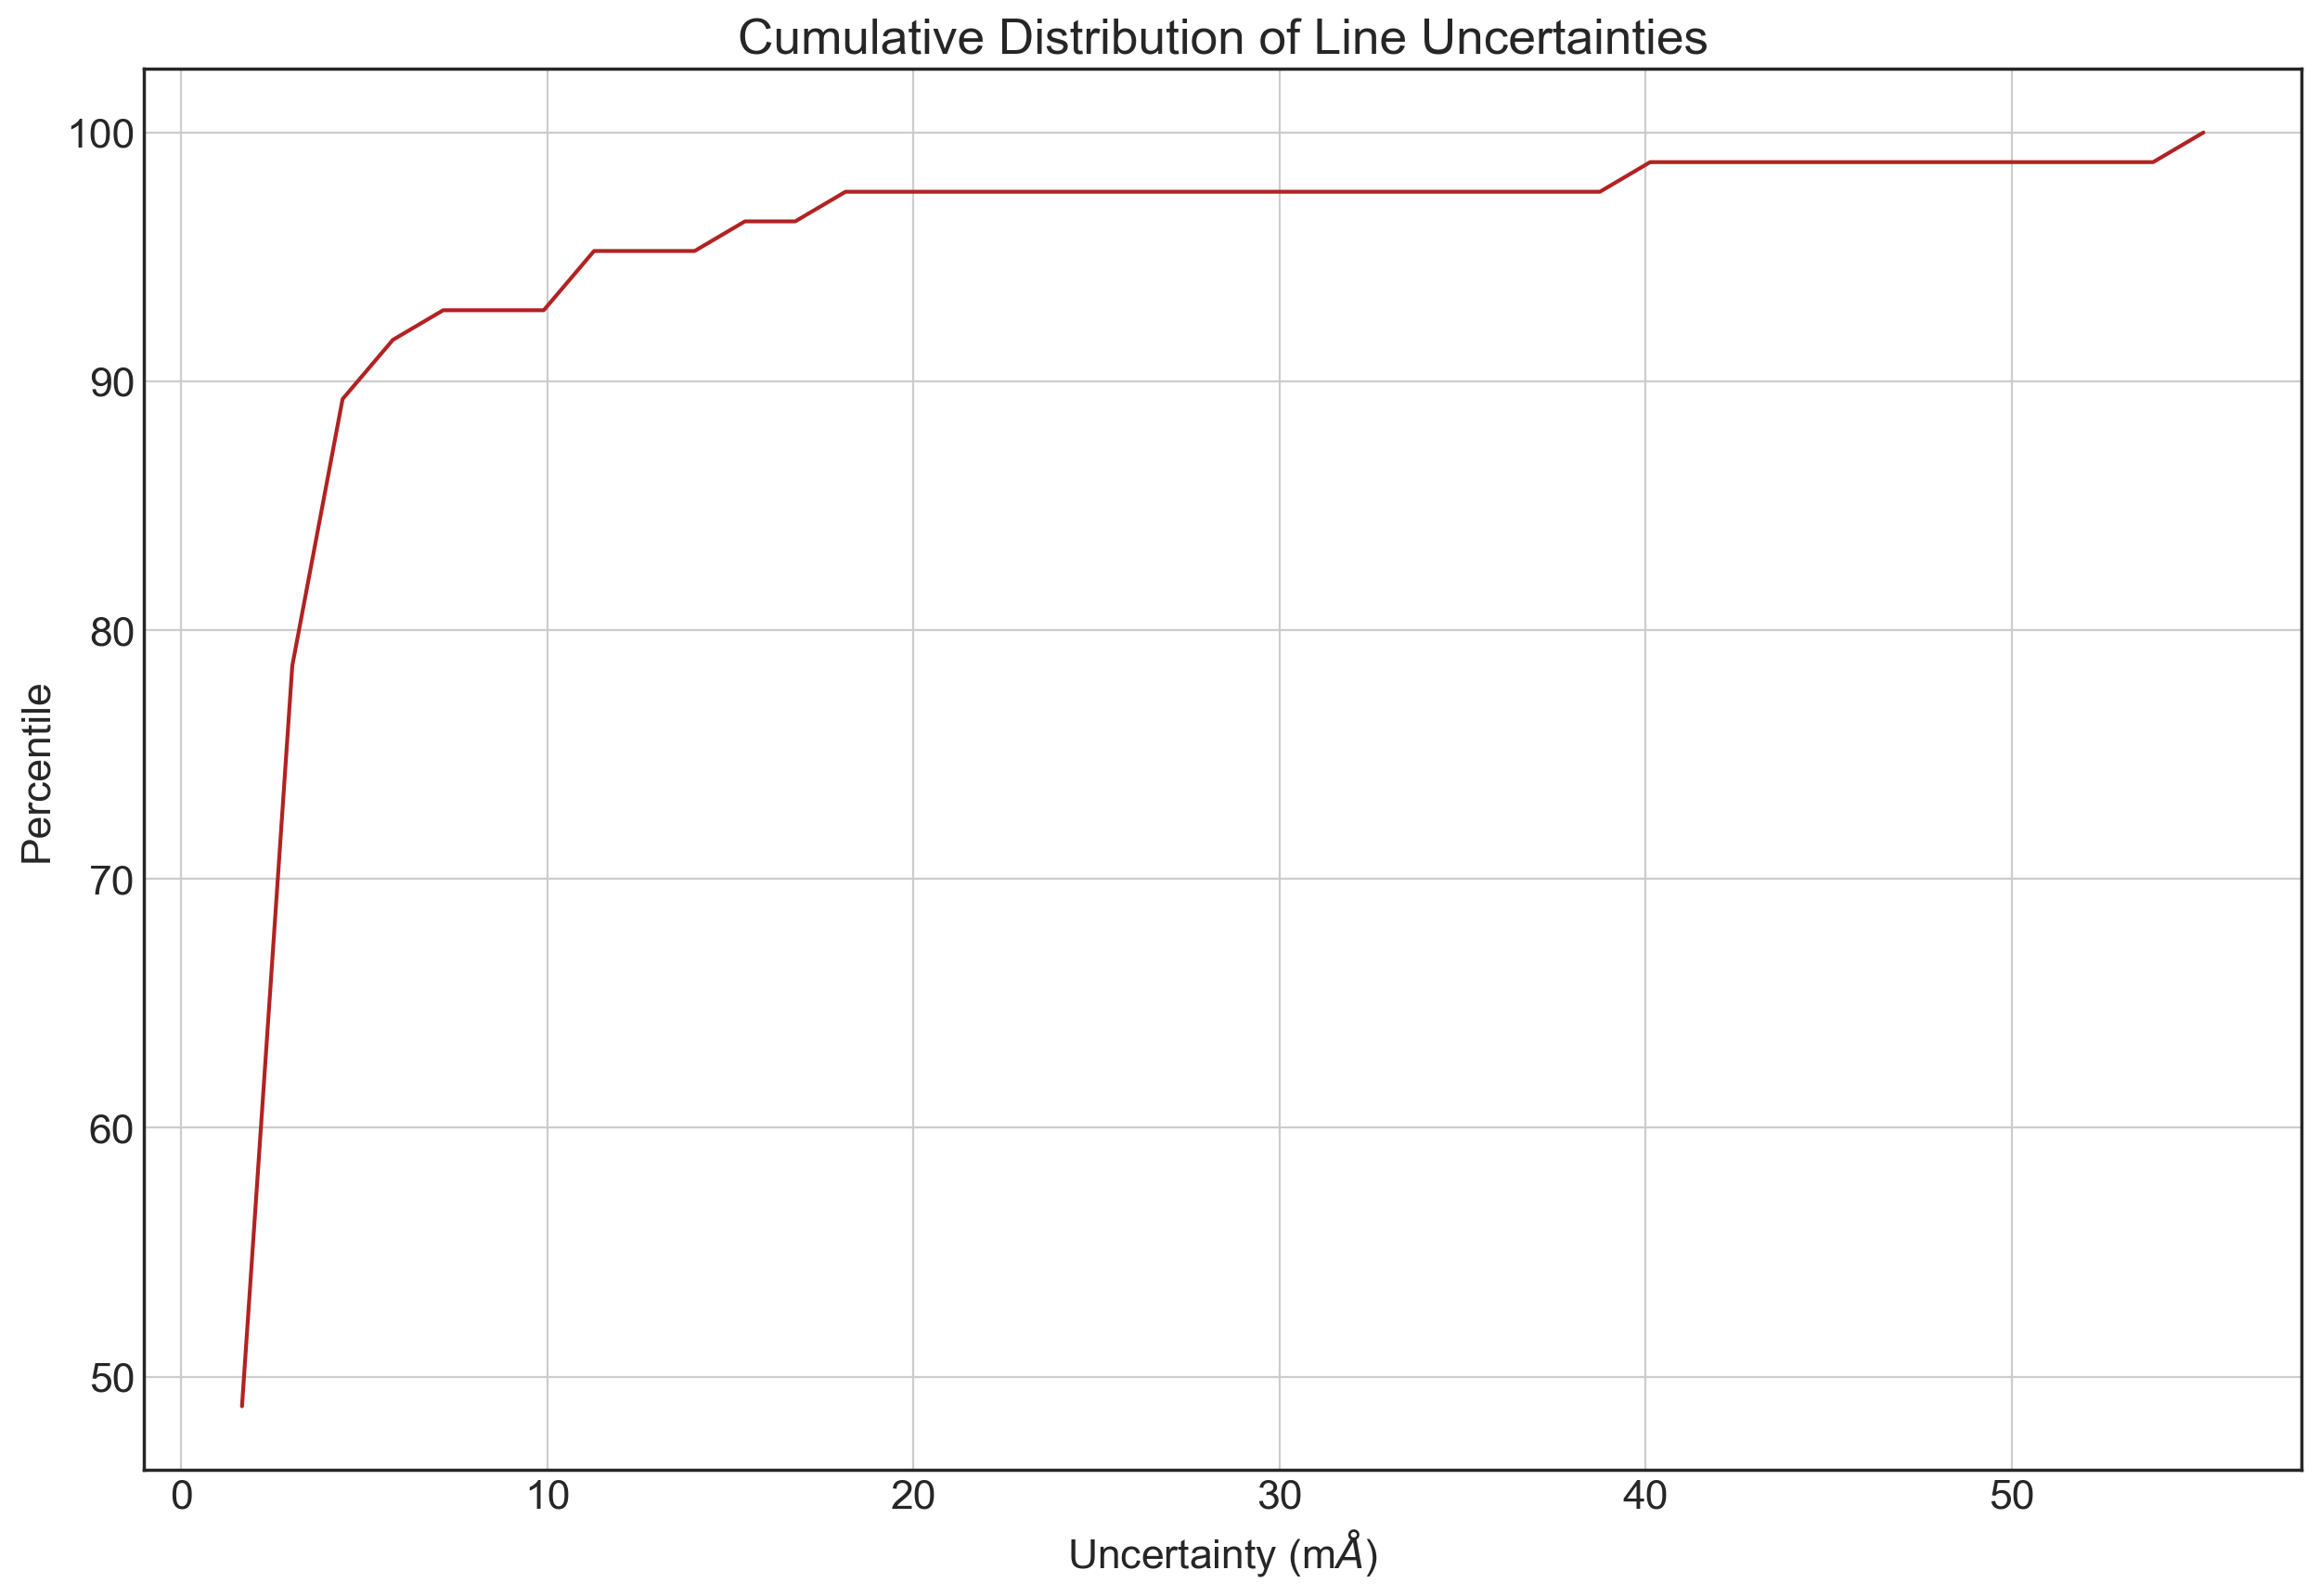

In [122]:
plt.figure(figsize=(15,10),dpi = 200)
plt.grid()

unc_values, unc_base = np.histogram(val_unc, bins=40)

#evaluate the cumulative
unc_cumulative = np.cumsum(unc_values)

# plot the cumulative function
plt.plot(unc_base[:-1], unc_cumulative/len(val_unc)*100, c='firebrick',label = "Line Uncertainties")
plt.title("Cumulative Distribution of Line Uncertainties")
plt.ylabel("Percentile")
plt.xlabel(r"Uncertainty (m$\AA$)")
#plt.xlabel(r"Uncertainty (%)")

plt.savefig("absdiff_cumdist.png")

#Journal with tweaks?

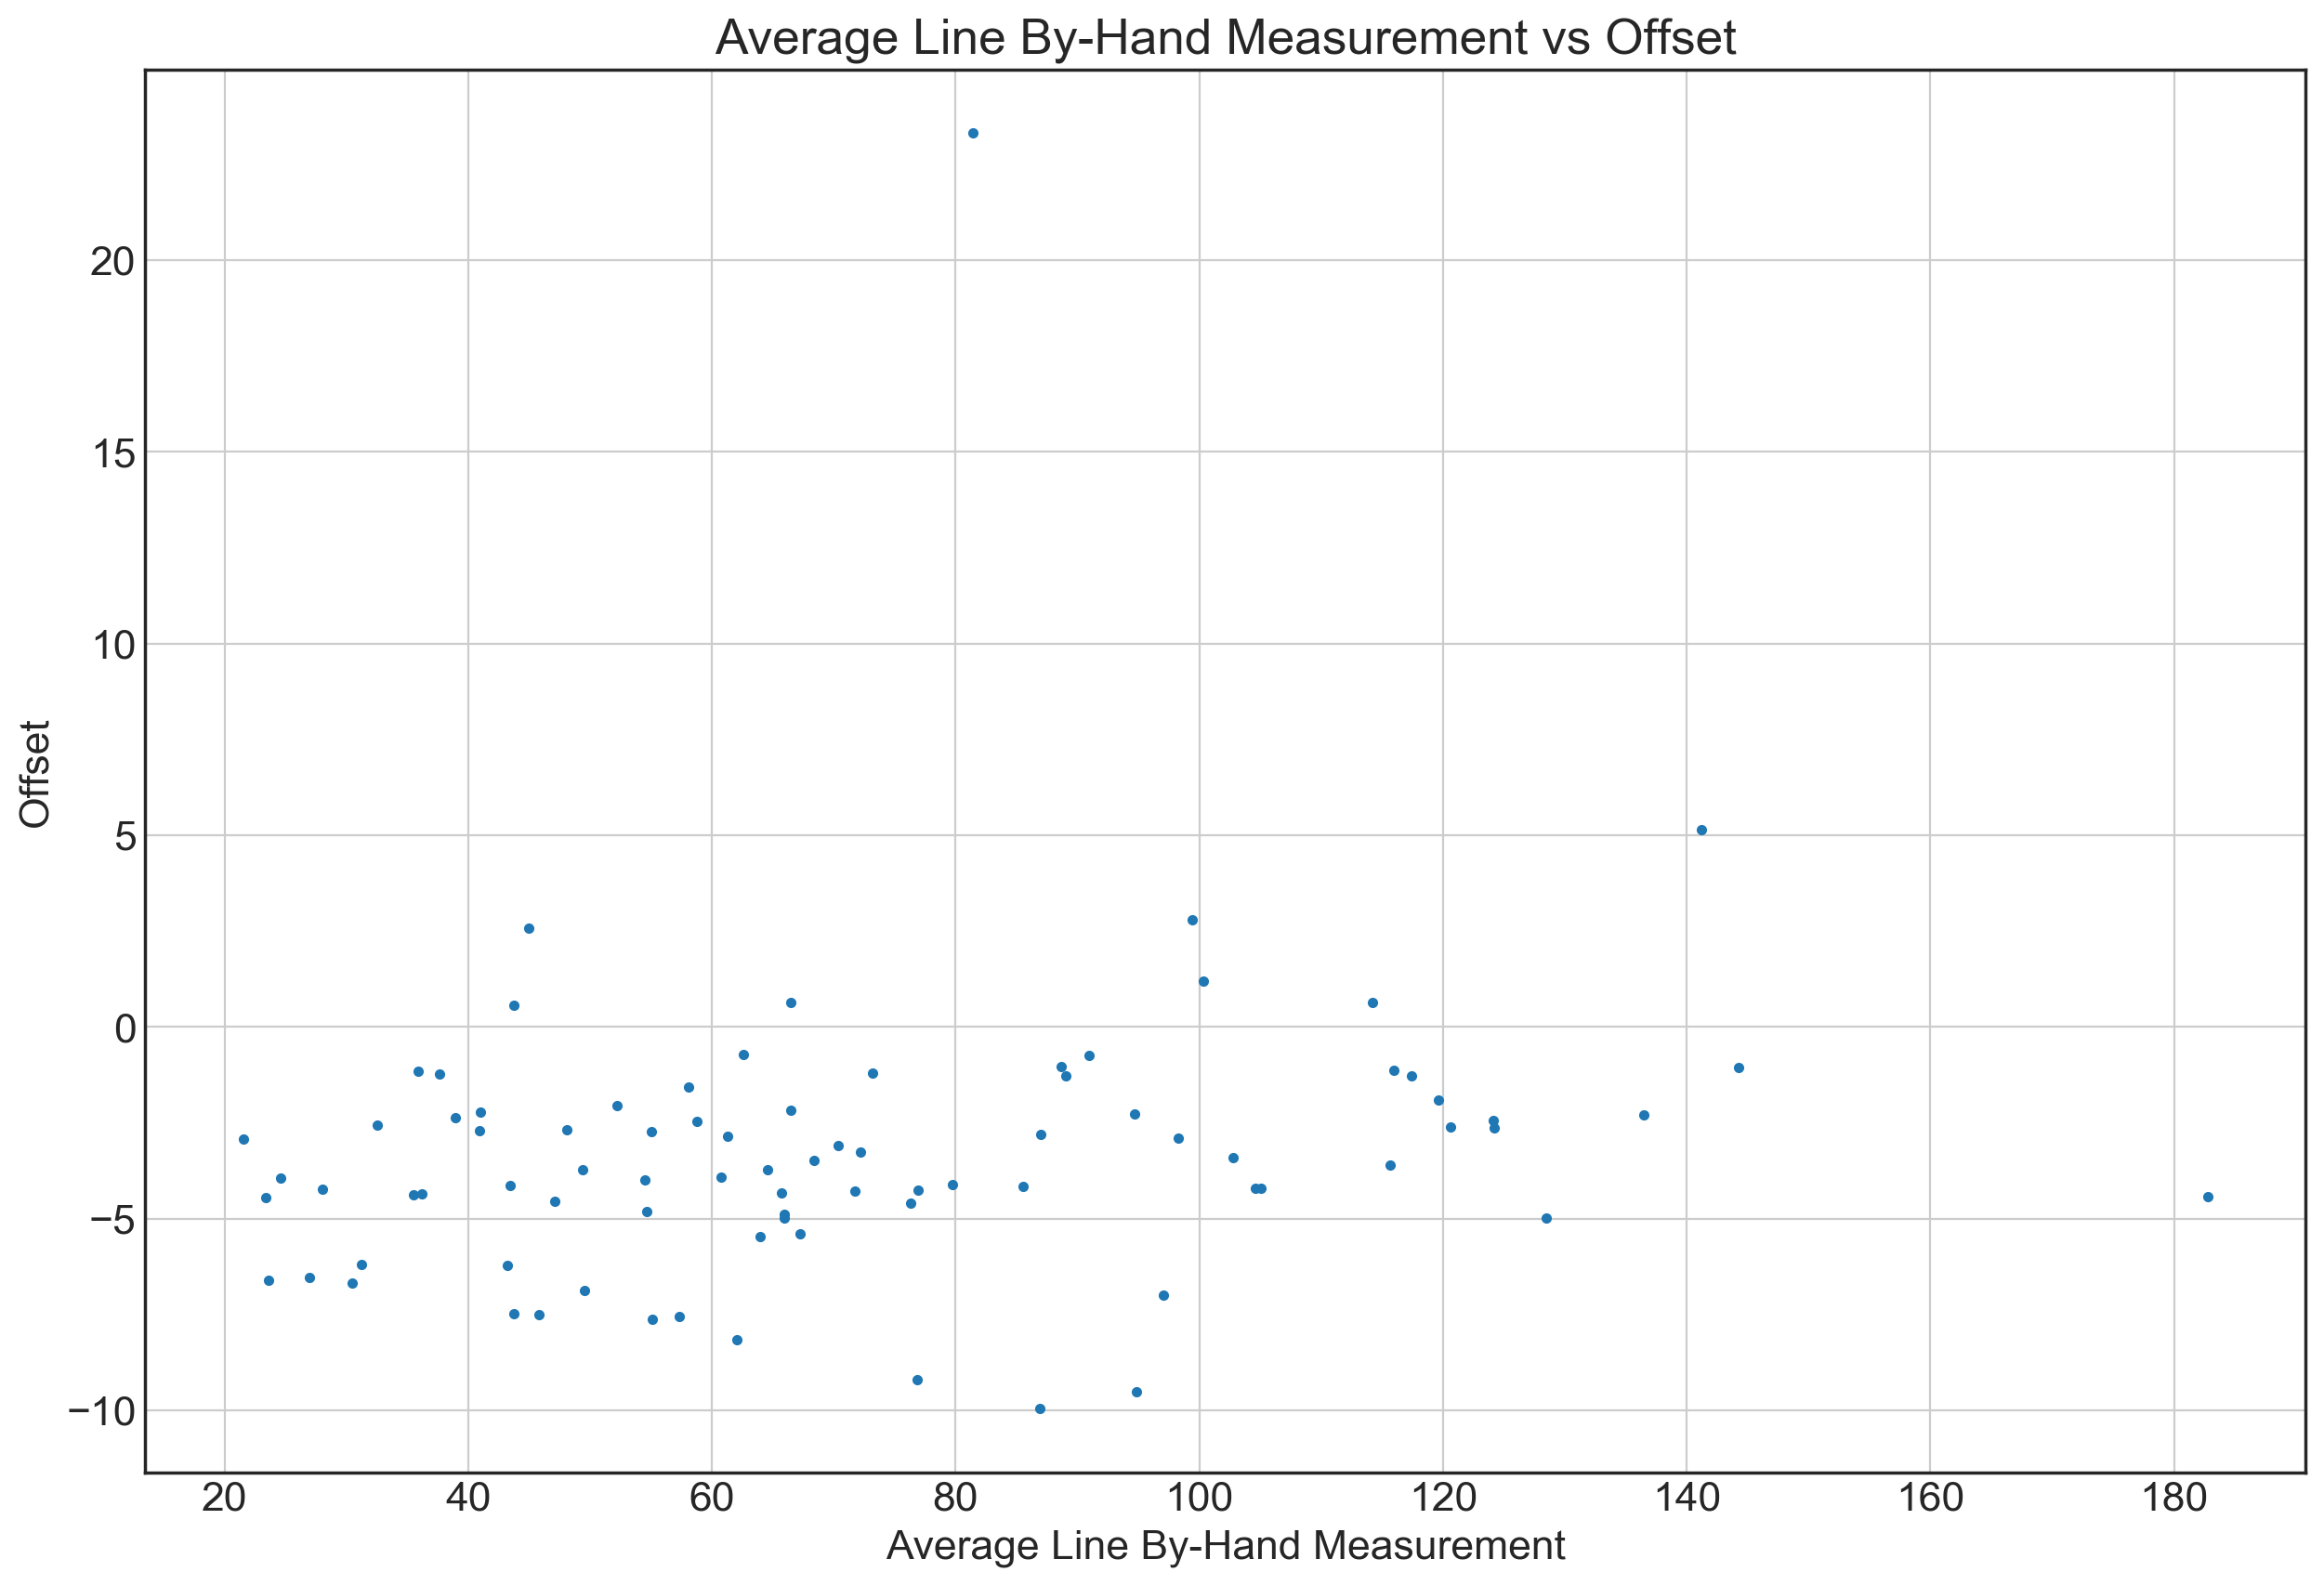

In [123]:
fig = plt.figure(figsize=(15,10))
plt.grid()
fig.dpi = 200

plt.plot(hand_meas, val_offst, '.')
plt.title("Average Line By-Hand Measurement vs Offset")
plt.ylabel("Offset")
plt.xlabel("Average Line By-Hand Measurement")

#plt.savefig("abs_offset_vs_ew.png")

#Journal?

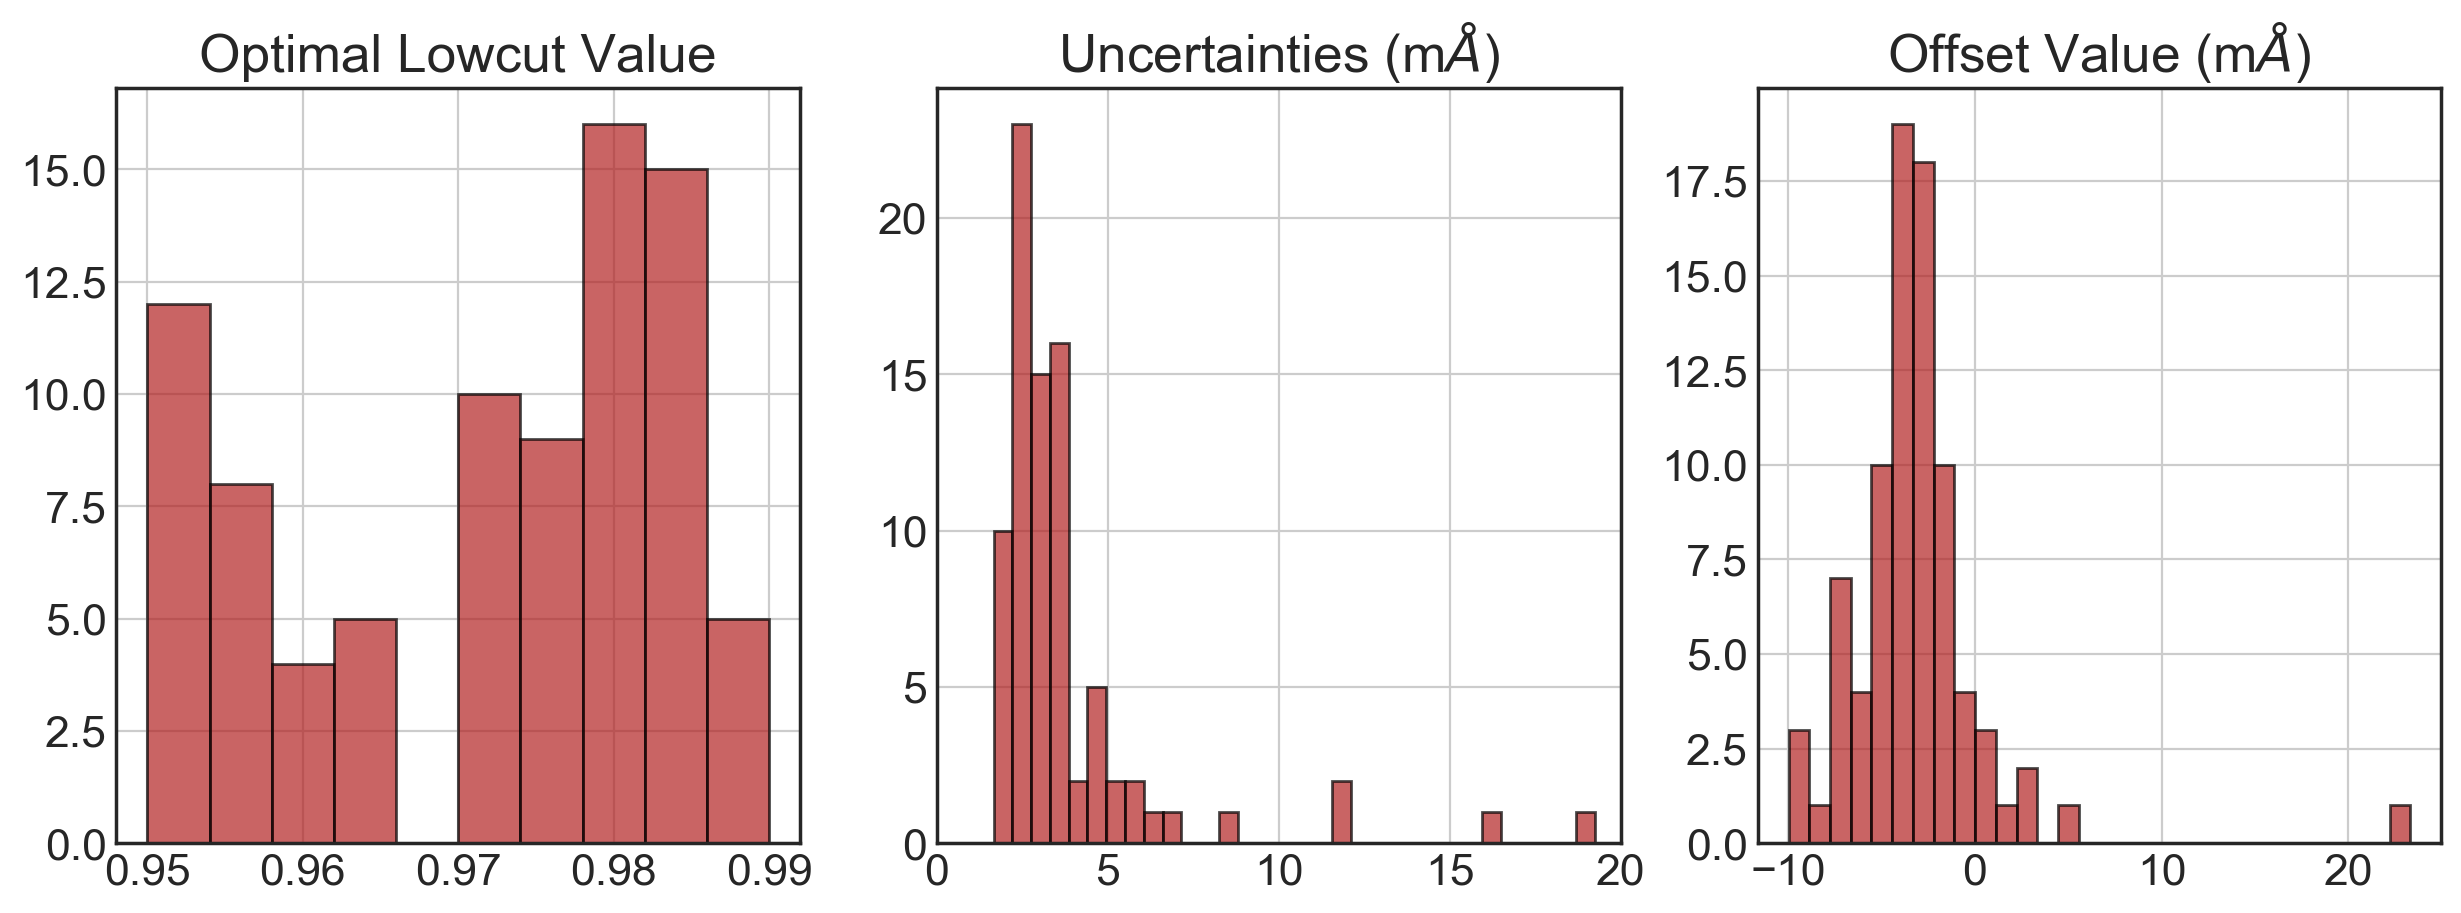

In [145]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5),dpi=200)

ax1.hist(opt_vals,histtype='bar',ec='black',alpha=0.7,color='firebrick',bins=10)
ax1.set_title("Optimal Lowcut Value")
ax1.grid()

ax2.hist(val_unc,histtype='bar',ec='black',alpha=0.7,color='firebrick',bins=100)
ax2.set_title(r"Uncertainties (m$\AA$)")
ax2.set_xlim(0,20)
ax2.grid()

ax3.hist(val_offst,histtype='bar',ec='black',alpha=0.7,color='firebrick',bins=30)
ax3.set_title(r"Offset Value (m$\AA$)")
ax3.grid()

(array([ 4.,  4.,  4.,  4.,  8.,  3.,  7.,  6.,  7.,  4.,  4.,  2.,  5.,
         2.,  4.,  3.,  0.,  4.,  2.,  3.,  0.,  1.,  2.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([  21.53875   ,   26.91249709,   32.28624419,   37.65999128,
          43.03373837,   48.40748547,   53.78123256,   59.15497965,
          64.52872674,   69.90247384,   75.27622093,   80.64996802,
          86.02371512,   91.39746221,   96.7712093 ,  102.1449564 ,
         107.51870349,  112.89245058,  118.26619767,  123.63994477,
         129.01369186,  134.38743895,  139.76118605,  145.13493314,
         150.50868023,  155.88242733,  161.25617442,  166.62992151,
         172.0036686 ,  177.3774157 ,  182.75116279]),
 <a list of 30 Patch objects>)

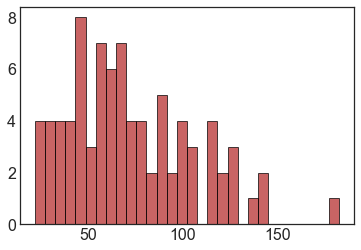

In [149]:
plt.hist(hand_meas,histtype='bar',ec='black',alpha=0.7,color='firebrick',bins=30)

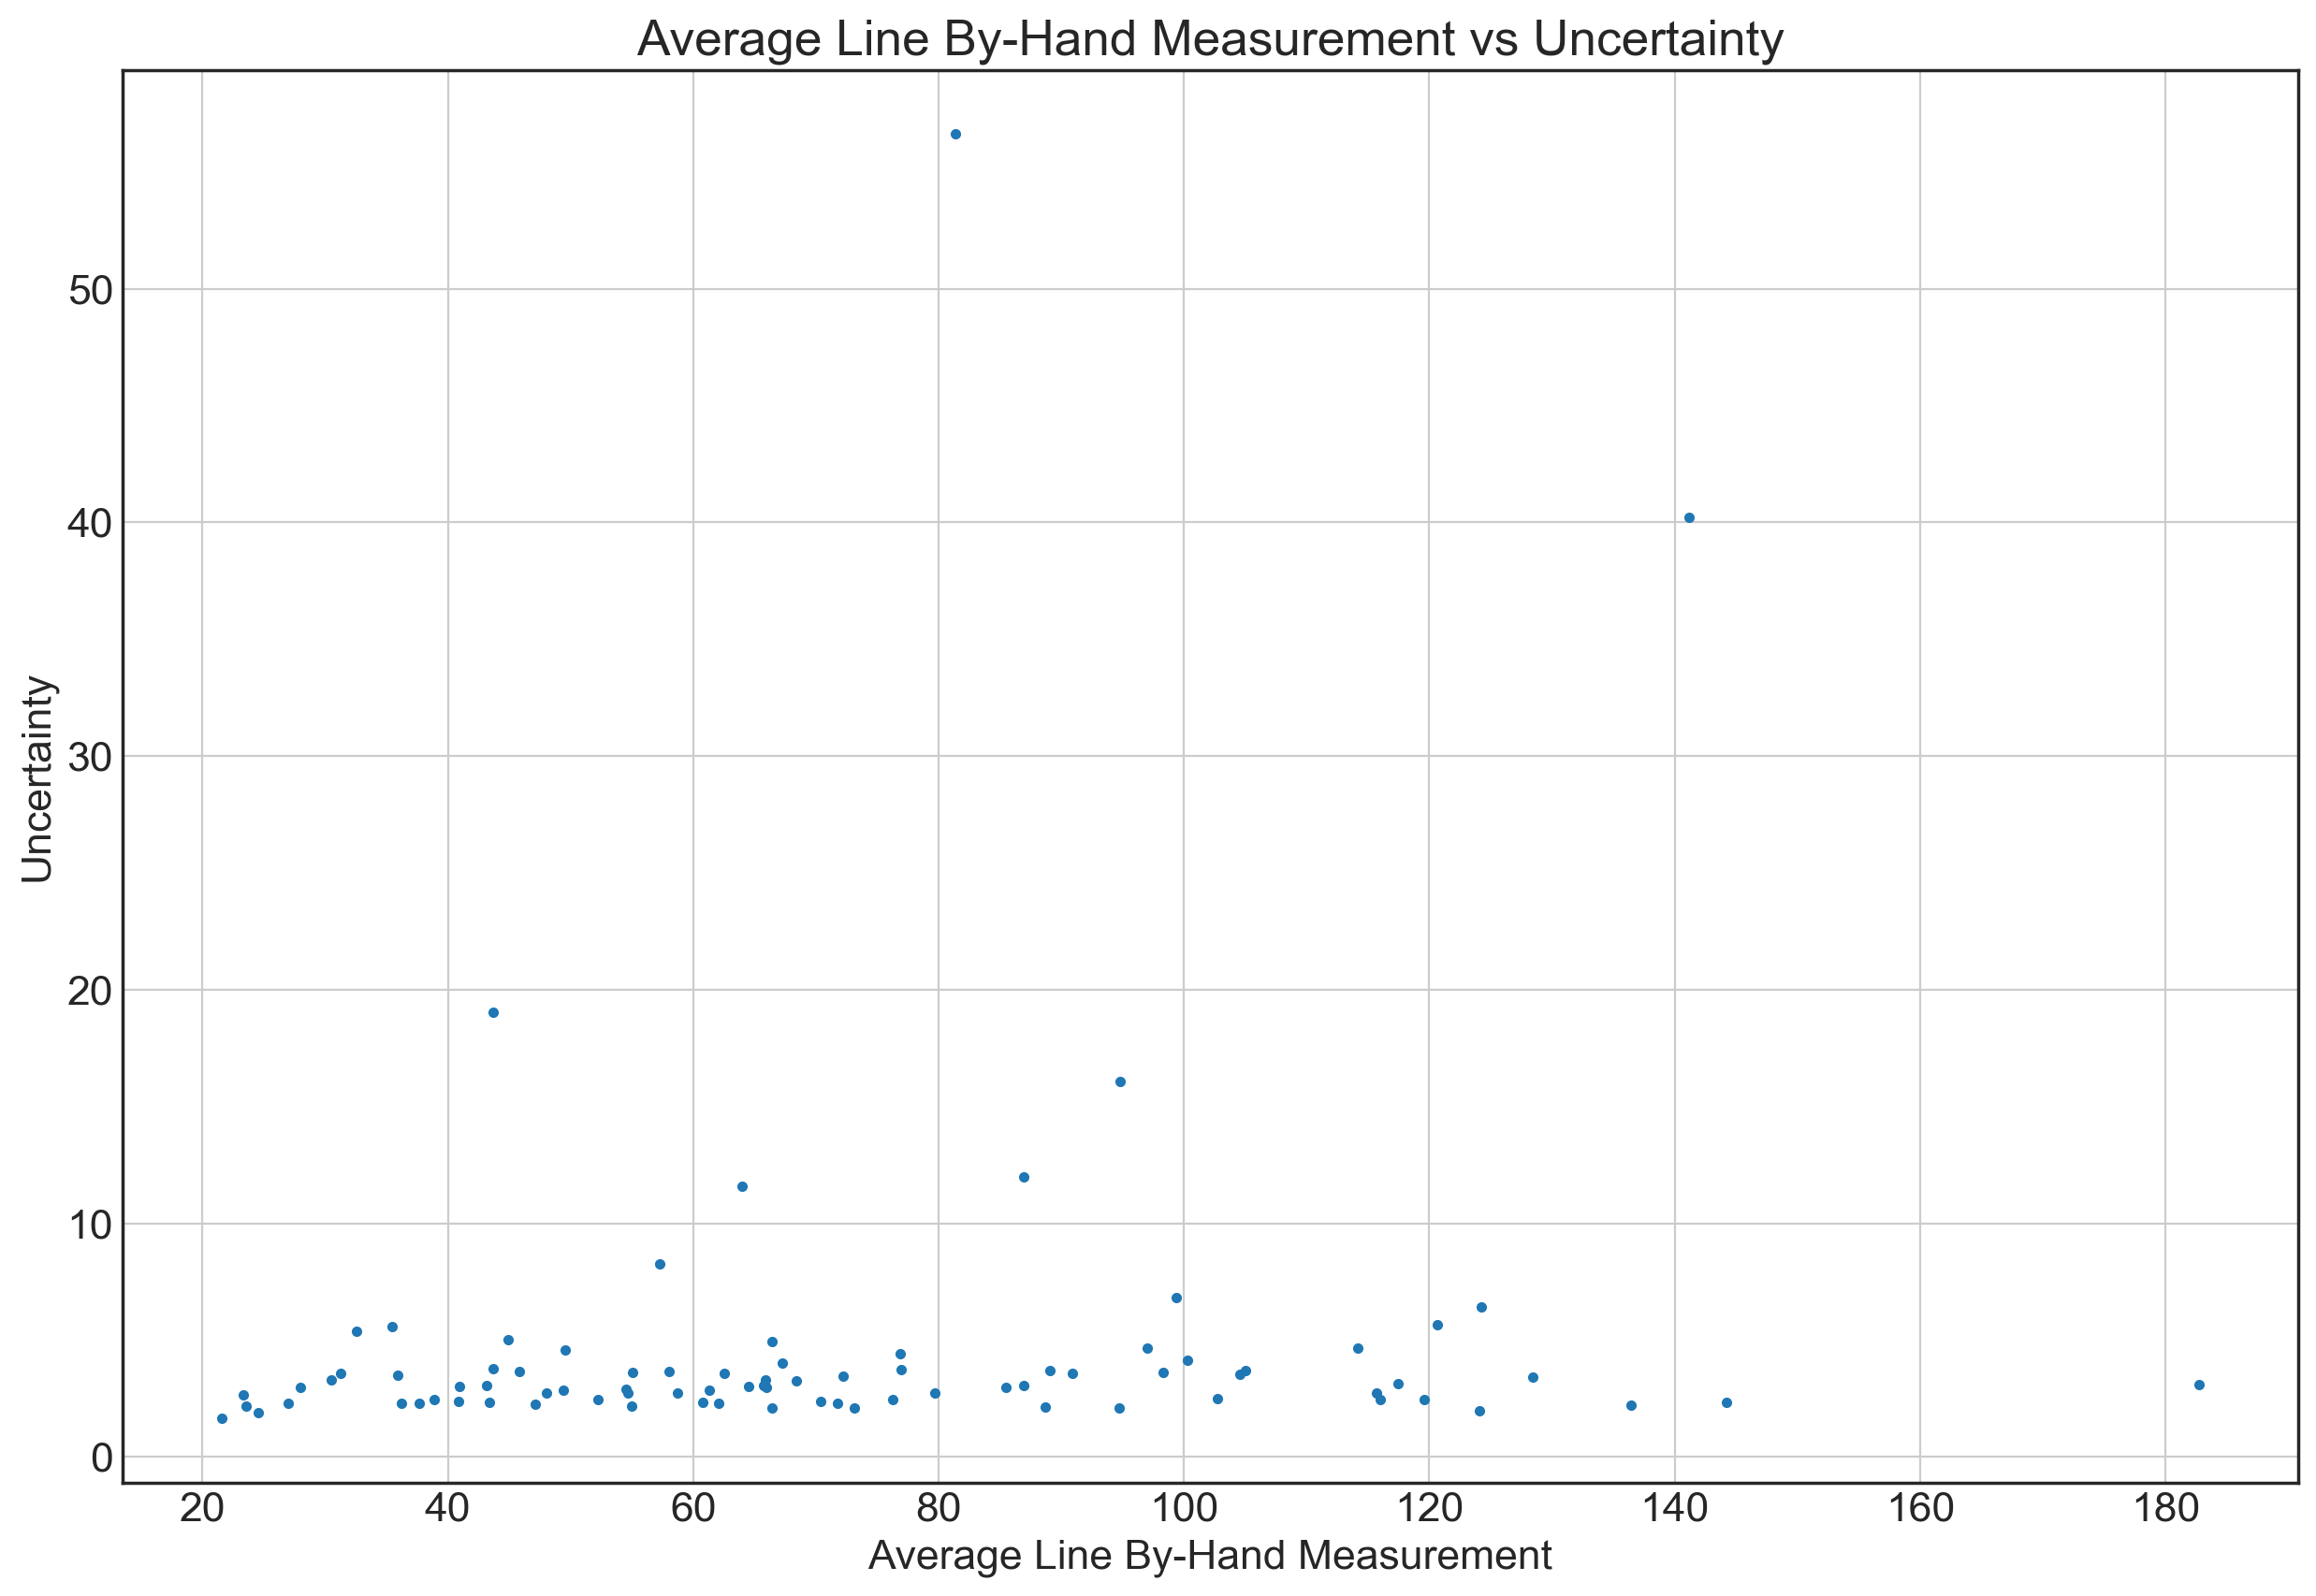

In [151]:
fig = plt.figure(figsize=(15,10))
plt.grid()
fig.dpi = 200

plt.plot(hand_meas, val_unc, '.')
plt.title("Average Line By-Hand Measurement vs Uncertainty")
plt.ylabel("Uncertainty")
plt.xlabel("Average Line By-Hand Measurement")

#Journal?

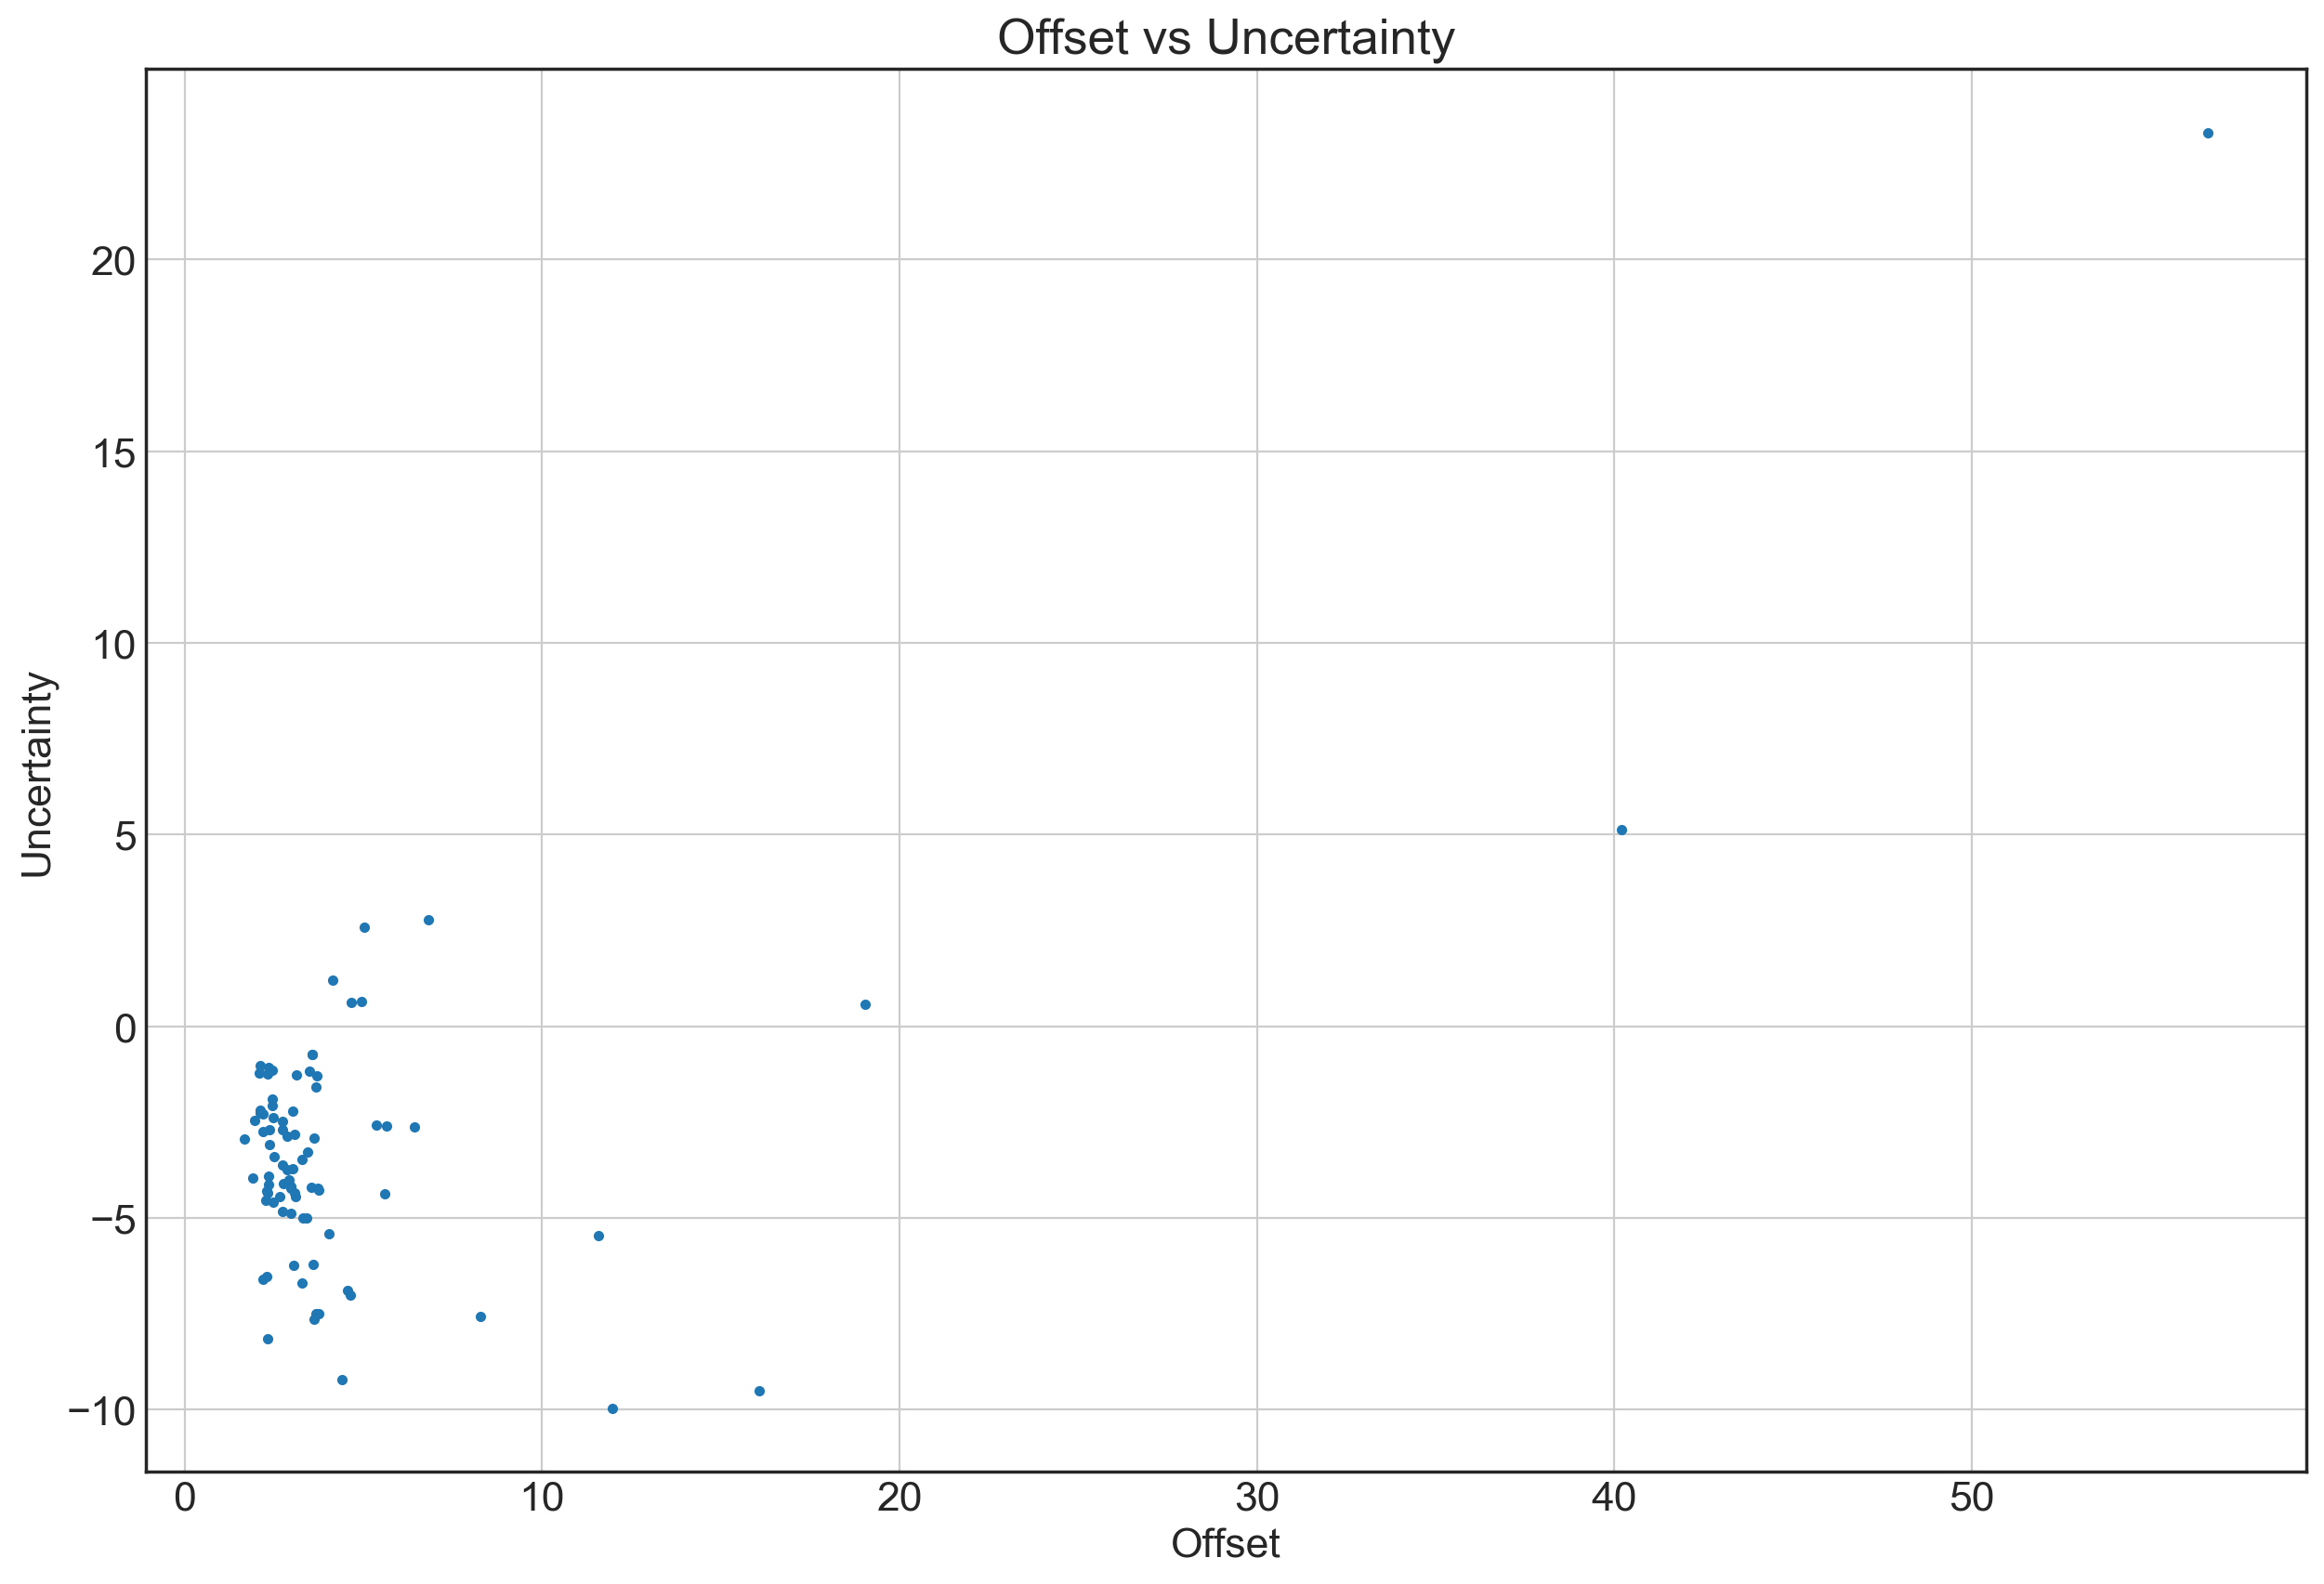

In [152]:
fig = plt.figure(figsize=(15,10))
plt.grid()
fig.dpi = 200

plt.plot(val_unc, val_offst, '.')
plt.title("Offset vs Uncertainty")
plt.ylabel("Uncertainty")
plt.xlabel("Offset")